# Antenna Radiation Pattern Analysis

## Introduction

An **antenna radiation pattern** describes the spatial distribution of electromagnetic energy radiated by an antenna as a function of direction. Understanding radiation patterns is fundamental to antenna design, wireless communications, radar systems, and radio astronomy.

## Theoretical Foundation

### Far-Field Radiation

In the far-field region (Fraunhofer zone), where $r \gg \frac{2D^2}{\lambda}$ (with $D$ being the antenna's largest dimension and $\lambda$ the wavelength), the electric field can be expressed as:

$$\vec{E}(r, \theta, \phi) = \frac{e^{-jkr}}{r} \vec{F}(\theta, \phi)$$

where:
- $k = \frac{2\pi}{\lambda}$ is the wave number
- $\vec{F}(\theta, \phi)$ is the **pattern function** containing all angular dependence
- $r$ is the distance from the antenna

### Radiation Intensity

The radiation intensity $U(\theta, \phi)$ is defined as the power radiated per unit solid angle:

$$U(\theta, \phi) = \frac{r^2}{2\eta} |\vec{E}|^2 = \frac{|\vec{F}(\theta, \phi)|^2}{2\eta}$$

where $\eta \approx 377\,\Omega$ is the intrinsic impedance of free space.

### Normalized Pattern

The normalized radiation pattern is:

$$F_n(\theta, \phi) = \frac{|\vec{F}(\theta, \phi)|}{|\vec{F}|_{\max}}$$

## Common Antenna Types

### 1. Isotropic Radiator

A theoretical antenna radiating equally in all directions:

$$F_n(\theta, \phi) = 1$$

### 2. Short Dipole (Hertzian Dipole)

For a short dipole of length $\ell \ll \lambda$ aligned along the z-axis:

$$F_n(\theta) = |\sin\theta|$$

This creates a **donut-shaped** pattern with nulls along the axis of the dipole.

### 3. Half-Wave Dipole

For a half-wave dipole ($\ell = \lambda/2$):

$$F_n(\theta) = \left|\frac{\cos\left(\frac{\pi}{2}\cos\theta\right)}{\sin\theta}\right|$$

### 4. Linear Antenna Array

For $N$ identical elements with spacing $d$ and progressive phase shift $\beta$, the **array factor** is:

$$AF(\theta) = \frac{\sin\left(\frac{N\psi}{2}\right)}{\sin\left(\frac{\psi}{2}\right)}$$

where the phase difference between adjacent elements is:

$$\psi = kd\cos\theta + \beta$$

### Directivity and Beam Parameters

**Directivity** $D$ measures how well an antenna concentrates power:

$$D = \frac{4\pi U_{\max}}{P_{rad}} = \frac{4\pi}{\int_0^{2\pi}\int_0^{\pi} |F_n(\theta,\phi)|^2 \sin\theta\, d\theta\, d\phi}$$

The **Half-Power Beamwidth (HPBW)** is the angular width where power drops to half (-3 dB).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set up high-quality plotting
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

In [2]:
def short_dipole_pattern(theta):
    """
    Normalized radiation pattern for a short (Hertzian) dipole.
    
    Parameters:
        theta: Angle from dipole axis (radians)
    
    Returns:
        Normalized field pattern |sin(theta)|
    """
    return np.abs(np.sin(theta))


def half_wave_dipole_pattern(theta):
    """
    Normalized radiation pattern for a half-wave dipole.
    
    Parameters:
        theta: Angle from dipole axis (radians)
    
    Returns:
        Normalized field pattern
    """
    # Handle singularities at theta = 0 and pi
    with np.errstate(divide='ignore', invalid='ignore'):
        pattern = np.abs(np.cos(np.pi/2 * np.cos(theta)) / np.sin(theta))
        # Replace NaN/inf with 0 (nulls at poles)
        pattern = np.nan_to_num(pattern, nan=0.0, posinf=0.0, neginf=0.0)
    return pattern / np.max(pattern) if np.max(pattern) > 0 else pattern


def array_factor(theta, N, d_lambda, beta=0):
    """
    Array factor for a uniform linear array.
    
    Parameters:
        theta: Angle from array axis (radians)
        N: Number of elements
        d_lambda: Element spacing in wavelengths (d/λ)
        beta: Progressive phase shift (radians)
    
    Returns:
        Normalized array factor
    """
    k = 2 * np.pi  # Normalized wave number (for d in wavelengths)
    psi = k * d_lambda * np.cos(theta) + beta
    
    with np.errstate(divide='ignore', invalid='ignore'):
        AF = np.sin(N * psi / 2) / (N * np.sin(psi / 2))
        AF = np.nan_to_num(AF, nan=1.0)  # L'Hôpital's rule at psi=0
    
    return np.abs(AF)

In [3]:
def calculate_directivity(pattern_func, *args, num_points=1000):
    """
    Calculate directivity for an azimuthally symmetric pattern.
    
    D = 4π / ∫|F_n(θ)|² sin(θ) dθ dφ
    
    For azimuthally symmetric patterns, this simplifies to:
    D = 2 / ∫|F_n(θ)|² sin(θ) dθ
    """
    theta = np.linspace(0, np.pi, num_points)
    pattern = pattern_func(theta, *args)
    
    # Normalize pattern
    pattern_normalized = pattern / np.max(pattern)
    
    # Numerical integration using trapezoidal rule
    integrand = pattern_normalized**2 * np.sin(theta)
    integral = np.trapz(integrand, theta)
    
    directivity = 2 / integral
    directivity_dB = 10 * np.log10(directivity)
    
    return directivity, directivity_dB


def calculate_hpbw(theta, pattern):
    """
    Calculate Half-Power Beamwidth (HPBW).
    
    Returns the angular width where power drops to 0.5 (-3 dB).
    """
    pattern_normalized = pattern / np.max(pattern)
    power_pattern = pattern_normalized**2
    
    # Find the main beam maximum
    max_idx = np.argmax(power_pattern)
    
    # Find -3dB points (power = 0.5)
    half_power = 0.5
    
    # Search left of maximum
    left_idx = max_idx
    for i in range(max_idx, -1, -1):
        if power_pattern[i] <= half_power:
            left_idx = i
            break
    
    # Search right of maximum
    right_idx = max_idx
    for i in range(max_idx, len(power_pattern)):
        if power_pattern[i] <= half_power:
            right_idx = i
            break
    
    hpbw_rad = theta[right_idx] - theta[left_idx]
    hpbw_deg = np.degrees(hpbw_rad)
    
    return hpbw_deg

In [4]:
# Create angular arrays
theta = np.linspace(0, np.pi, 1000)  # 0 to 180 degrees
theta_full = np.linspace(0, 2*np.pi, 2000)  # Full 360 for polar plots

# Calculate patterns
# Short dipole
F_short = short_dipole_pattern(theta)
F_short_polar = short_dipole_pattern(theta_full)

# Half-wave dipole
F_half = half_wave_dipole_pattern(theta)
F_half_polar = half_wave_dipole_pattern(theta_full)

# Array factors with different configurations
# Broadside array (N=4, d=λ/2, β=0)
AF_broadside = array_factor(theta, N=4, d_lambda=0.5, beta=0)
AF_broadside_polar = array_factor(theta_full, N=4, d_lambda=0.5, beta=0)

# End-fire array (N=4, d=λ/4, β=-kd)
d_endfire = 0.25
beta_endfire = -2 * np.pi * d_endfire  # Hansen-Woodyard condition approximation
AF_endfire = array_factor(theta, N=4, d_lambda=d_endfire, beta=beta_endfire)
AF_endfire_polar = array_factor(theta_full, N=4, d_lambda=d_endfire, beta=beta_endfire)

# Calculate directivities
D_short, D_short_dB = calculate_directivity(short_dipole_pattern)
D_half, D_half_dB = calculate_directivity(half_wave_dipole_pattern)

print("Antenna Directivity Calculations")
print("="*40)
print(f"Short Dipole: D = {D_short:.3f} ({D_short_dB:.2f} dBi)")
print(f"Half-Wave Dipole: D = {D_half:.3f} ({D_half_dB:.2f} dBi)")
print(f"\nTheoretical values:")
print(f"Short Dipole: D = 1.5 (1.76 dBi)")
print(f"Half-Wave Dipole: D = 1.64 (2.15 dBi)")

Antenna Directivity Calculations
Short Dipole: D = 1.500 (1.76 dBi)
Half-Wave Dipole: D = 1.641 (2.15 dBi)

Theoretical values:
Short Dipole: D = 1.5 (1.76 dBi)
Half-Wave Dipole: D = 1.64 (2.15 dBi)


/tmp/ipykernel_150895/198159617.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrand, theta)


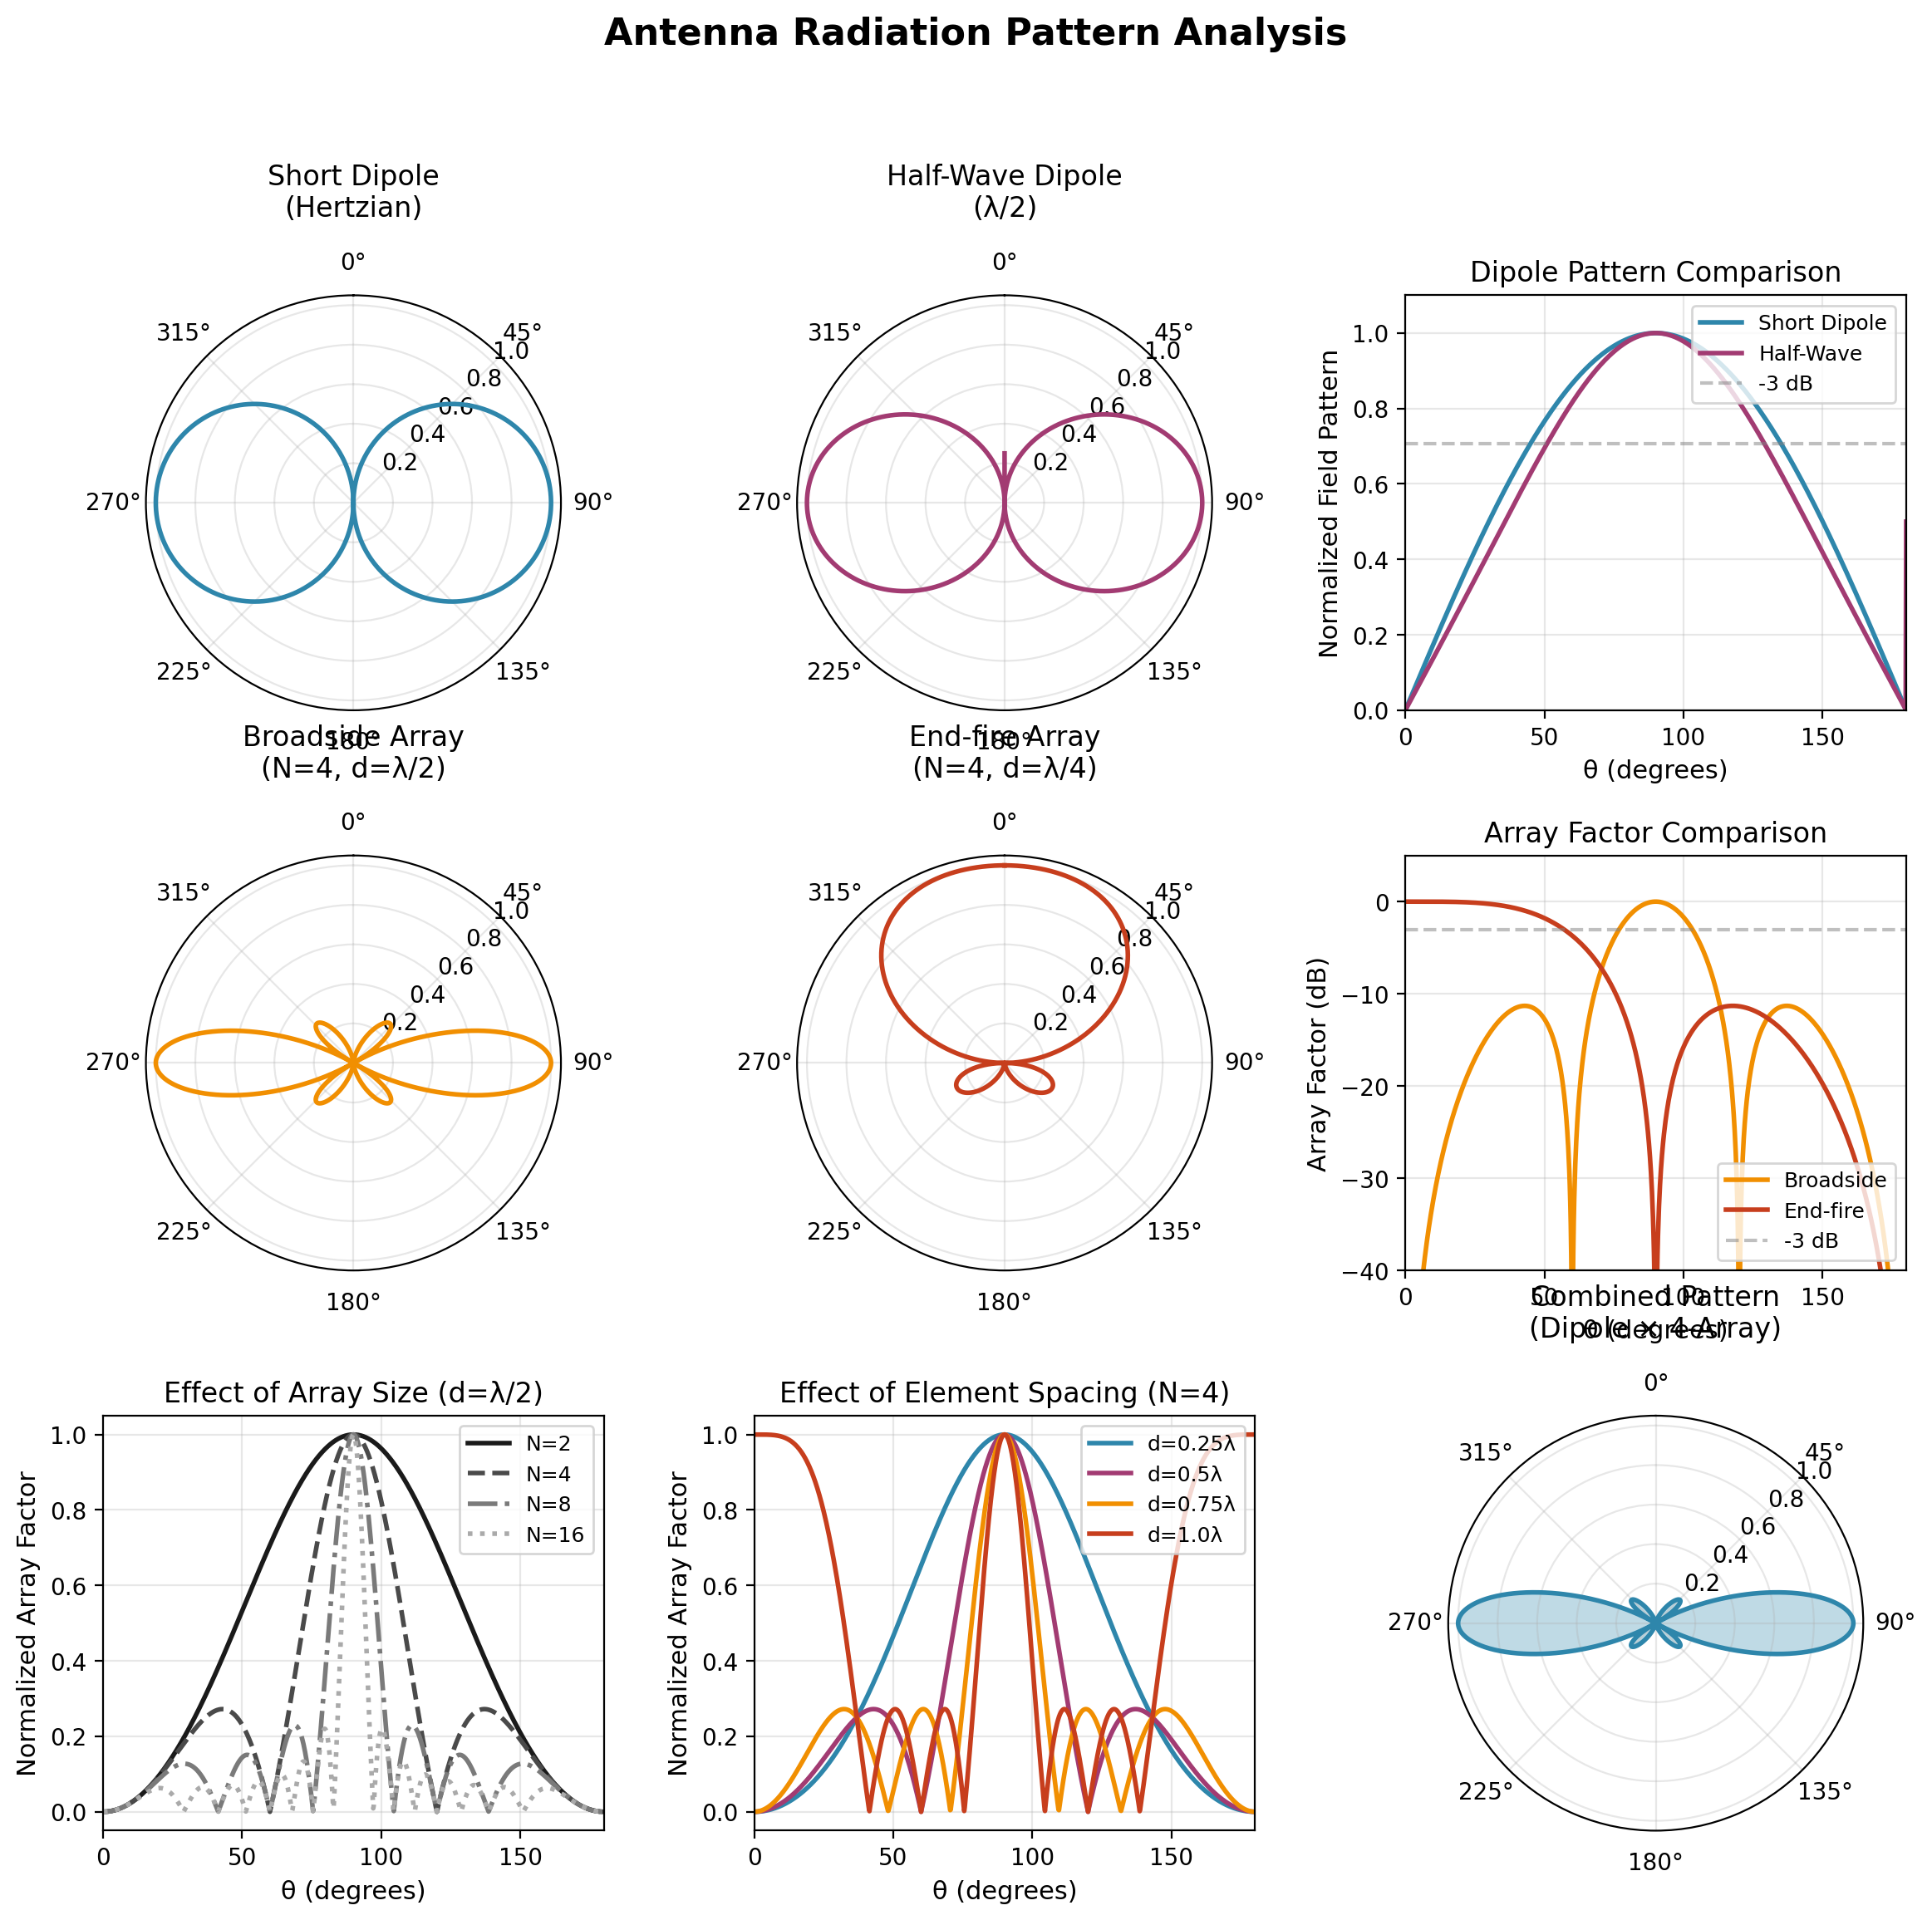


Figure saved to 'plot.png'


In [5]:
# Create comprehensive figure
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# Color scheme
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# =============================================================================
# Row 1: Dipole Patterns (Polar and Cartesian)
# =============================================================================

# Polar plot - Short Dipole
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
ax1.plot(theta_full, F_short_polar, color=colors[0], linewidth=2)
ax1.set_title('Short Dipole\n(Hertzian)', pad=15)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(45)
ax1.grid(True, alpha=0.3)

# Polar plot - Half-Wave Dipole
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax2.plot(theta_full, F_half_polar, color=colors[1], linewidth=2)
ax2.set_title('Half-Wave Dipole\n(λ/2)', pad=15)
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(45)
ax2.grid(True, alpha=0.3)

# Cartesian comparison
ax3 = fig.add_subplot(gs[0, 2])
theta_deg = np.degrees(theta)
ax3.plot(theta_deg, F_short, color=colors[0], linewidth=2, label='Short Dipole')
ax3.plot(theta_deg, F_half, color=colors[1], linewidth=2, label='Half-Wave')
ax3.axhline(y=0.707, color='gray', linestyle='--', alpha=0.5, label='-3 dB')
ax3.set_xlabel('θ (degrees)')
ax3.set_ylabel('Normalized Field Pattern')
ax3.set_title('Dipole Pattern Comparison')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 180])
ax3.set_ylim([0, 1.1])

# =============================================================================
# Row 2: Array Patterns
# =============================================================================

# Polar plot - Broadside Array
ax4 = fig.add_subplot(gs[1, 0], projection='polar')
ax4.plot(theta_full, AF_broadside_polar, color=colors[2], linewidth=2)
ax4.set_title('Broadside Array\n(N=4, d=λ/2)', pad=15)
ax4.set_theta_zero_location('N')
ax4.set_theta_direction(-1)
ax4.set_rlabel_position(45)
ax4.grid(True, alpha=0.3)

# Polar plot - End-fire Array
ax5 = fig.add_subplot(gs[1, 1], projection='polar')
ax5.plot(theta_full, AF_endfire_polar, color=colors[3], linewidth=2)
ax5.set_title('End-fire Array\n(N=4, d=λ/4)', pad=15)
ax5.set_theta_zero_location('N')
ax5.set_theta_direction(-1)
ax5.set_rlabel_position(45)
ax5.grid(True, alpha=0.3)

# Array factor comparison in dB
ax6 = fig.add_subplot(gs[1, 2])
# Convert to dB (with floor to avoid -inf)
AF_broad_dB = 20 * np.log10(np.maximum(AF_broadside, 1e-6))
AF_end_dB = 20 * np.log10(np.maximum(AF_endfire, 1e-6))
ax6.plot(theta_deg, AF_broad_dB, color=colors[2], linewidth=2, label='Broadside')
ax6.plot(theta_deg, AF_end_dB, color=colors[3], linewidth=2, label='End-fire')
ax6.axhline(y=-3, color='gray', linestyle='--', alpha=0.5, label='-3 dB')
ax6.set_xlabel('θ (degrees)')
ax6.set_ylabel('Array Factor (dB)')
ax6.set_title('Array Factor Comparison')
ax6.legend(loc='lower right', fontsize=9)
ax6.grid(True, alpha=0.3)
ax6.set_xlim([0, 180])
ax6.set_ylim([-40, 5])

# =============================================================================
# Row 3: Effect of Array Size and 3D Visualization
# =============================================================================

# Effect of number of elements
ax7 = fig.add_subplot(gs[2, 0])
for N, color, ls in [(2, '#1a1a1a', '-'), (4, '#4a4a4a', '--'), 
                      (8, '#7a7a7a', '-.'), (16, '#aaaaaa', ':')]:
    AF_N = array_factor(theta, N=N, d_lambda=0.5, beta=0)
    ax7.plot(theta_deg, AF_N, color=color, linewidth=2, linestyle=ls, label=f'N={N}')
ax7.set_xlabel('θ (degrees)')
ax7.set_ylabel('Normalized Array Factor')
ax7.set_title('Effect of Array Size (d=λ/2)')
ax7.legend(loc='upper right', fontsize=9)
ax7.grid(True, alpha=0.3)
ax7.set_xlim([0, 180])

# Effect of element spacing
ax8 = fig.add_subplot(gs[2, 1])
for d, color in [(0.25, '#2E86AB'), (0.5, '#A23B72'), 
                  (0.75, '#F18F01'), (1.0, '#C73E1D')]:
    AF_d = array_factor(theta, N=4, d_lambda=d, beta=0)
    ax8.plot(theta_deg, AF_d, color=color, linewidth=2, label=f'd={d}λ')
ax8.set_xlabel('θ (degrees)')
ax8.set_ylabel('Normalized Array Factor')
ax8.set_title('Effect of Element Spacing (N=4)')
ax8.legend(loc='upper right', fontsize=9)
ax8.grid(True, alpha=0.3)
ax8.set_xlim([0, 180])

# 3D-like visualization using filled polar plot
ax9 = fig.add_subplot(gs[2, 2], projection='polar')
# Combined pattern: half-wave dipole × 4-element array
combined_pattern = F_half_polar * array_factor(theta_full, N=4, d_lambda=0.5, beta=0)
combined_pattern = combined_pattern / np.max(combined_pattern)
ax9.fill(theta_full, combined_pattern, alpha=0.3, color=colors[0])
ax9.plot(theta_full, combined_pattern, color=colors[0], linewidth=2)
ax9.set_title('Combined Pattern\n(Dipole × 4-Array)', pad=15)
ax9.set_theta_zero_location('N')
ax9.set_theta_direction(-1)
ax9.set_rlabel_position(45)
ax9.grid(True, alpha=0.3)

plt.suptitle('Antenna Radiation Pattern Analysis', fontsize=16, fontweight='bold', y=1.02)

# Save the figure
plt.savefig('antenna_radiation_pattern_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to 'plot.png'")

In [6]:
# Additional analysis: Calculate and display HPBW for various configurations
print("\nHalf-Power Beamwidth (HPBW) Analysis")
print("="*45)

# For patterns symmetric about θ=90°
theta_fine = np.linspace(0, np.pi, 10000)

# Short dipole HPBW
F_s = short_dipole_pattern(theta_fine)
hpbw_short = calculate_hpbw(theta_fine, F_s)
print(f"Short Dipole HPBW: {hpbw_short:.1f}°")

# Half-wave dipole HPBW
F_h = half_wave_dipole_pattern(theta_fine)
hpbw_half = calculate_hpbw(theta_fine, F_h)
print(f"Half-Wave Dipole HPBW: {hpbw_half:.1f}°")

# Array HPBWs
for N in [2, 4, 8, 16]:
    AF = array_factor(theta_fine, N=N, d_lambda=0.5, beta=0)
    hpbw = calculate_hpbw(theta_fine, AF)
    print(f"{N}-Element Broadside Array HPBW: {hpbw:.1f}°")

print("\nNote: Theoretical HPBW for N-element broadside array ≈ 0.886λ/(Nd)")


Half-Power Beamwidth (HPBW) Analysis
Short Dipole HPBW: 90.0°
Half-Wave Dipole HPBW: 78.1°
2-Element Broadside Array HPBW: 60.0°
4-Element Broadside Array HPBW: 26.3°
8-Element Broadside Array HPBW: 12.8°
16-Element Broadside Array HPBW: 6.4°

Note: Theoretical HPBW for N-element broadside array ≈ 0.886λ/(Nd)


## Summary and Key Observations

### Dipole Antennas
1. **Short dipole** produces a simple $\sin\theta$ pattern with directivity $D = 1.5$ (1.76 dBi)
2. **Half-wave dipole** has slightly higher directivity $D = 1.64$ (2.15 dBi) due to its narrower beamwidth
3. Both dipoles have **nulls along the axis** and **maximum radiation perpendicular** to the antenna

### Array Antennas
1. **Broadside arrays** (β = 0) produce maximum radiation perpendicular to the array axis
2. **End-fire arrays** direct maximum radiation along the array axis
3. Increasing the number of elements $N$ **narrows the main beam** and increases directivity
4. **Grating lobes** appear when element spacing $d > \lambda$ 

### Design Trade-offs
- **Beamwidth vs. Sidelobes**: Narrower beams typically come with higher sidelobes
- **Spacing vs. Grating Lobes**: Larger spacing increases directivity but risks grating lobes
- **Pattern Multiplication**: Total pattern = Element pattern × Array factor

### Applications
- **Communications**: Half-wave dipoles for omnidirectional coverage
- **Radar**: Large arrays for narrow, high-gain beams
- **Direction Finding**: Arrays with beam scanning capability
- **Radio Astronomy**: Very large arrays for extreme angular resolution